# Anxiety Analysis with an RNN

In this notebook, a recurrent neural network that performs anxiety analysis is implemented. We will use the communication data, together with some static variables to predict the GAD7 scores of patients. 

### Network Architecture
<code> 
AnxietyRNN(
  (rnn): RNN(2, 32, batch_first=True)
  (dropout): Dropout(p=0.3, inplace=False)
  (fc): Linear(in_features=26, out_features=10, bias=True)
  (sig): Sigmoid()
  (criterion): BCELoss()
)
</code>

>**The temporal data will be the input to RNN cells.** The RNN cells will add *recurrent* connections to the network and
 > give us the ability to include information about the *sequence* of observations in the communication data.

>**Then, the RNN outputs will be concatenated with the static features, and together go to a fully-connected layer,
> followed by a ReLU activation, and the fully-connected output layer.**

Leave-one-out cross-validation, or LOOCV, is a configuration of k-fold cross-validation where k is set to the number of
examples in the dataset.

LOOCV is an extreme version of k-fold cross-validation that has the maximum computational cost. It requires one model to
 be created and evaluated for each example in the training dataset.

The benefit of so many fit and evaluated models is a more robust estimate of model performance as each row of data is
given an opportunity to represent the entirety of the test dataset.

For more details see: https://machinelearningmastery.com/loocv-for-evaluating-machine-learning-algorithms/

In [109]:
# import necessary libraries/methods
import os

import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import LeaveOneOut
from sklearn.metrics import accuracy_score, roc_auc_score, average_precision_score

from src.utils import *
from src.rnn import AnxietyRNNExtended

# set up autoreload
%load_ext autoreload
%autoreload 2

# pandas settings
pd.set_option("display.max_columns", None)
pd.set_option("display.float_format", lambda x: "%.3f" % x)

# seaborn setting
sns.set_style("white")
sns.set_palette("colorblind")

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


---
## Load in the data

In [110]:
# load encoded EMA data
PATH_TO_DATA = None
df_ema_enc = pd.read_csv(PATH_TO_DATA + "EMA_data.csv")
ema_cols_enc = ["sc_age", "Sex", "Lives_Alone", "CurrentActivity", "Covid25", "Covid34", "Covid37", "Covid43"]

# load communication data and group by patient id
df_temp = pd.read_csv(PATH_TO_DATA + "temp_data.csv")
df_temp["date"] = pd.to_datetime(df_temp["date"], format = "%Y-%m-%d")

In [111]:
# create look-up table for patient ids
patient_lookup = {idx:pid for idx,pid in enumerate(df_temp.user.unique())}

### Pre-process the patient sequences

We want to make sure that our sequences are in good shape for standard processing. That is, our network will expect a standard input length, and so, we"ll want to shape our observation sequences into a specific length. In order to do this, we will pad the sequences so that we have sequences of the same length. 

In [112]:
t_features = pad_features(df_temp, ["comm_med", "social_med"])
nt_features = df_ema_enc[ema_cols_enc].values
labels = df_ema_enc.Anxiety_Group.values

---
## LOOCV

Given that the dataset has 104 examples, it means that 104 train/test splits of the dataset were created, with each single row of the dataset given an opportunity to be used as the test set. Similarly, 104 models are created, trained for 100 epochs and evaluated.

In [113]:
# define dictionary to store the evaluation metrics and other things to track the training
n_splits = len(labels)
n_epochs = 100
loo_dic = {
    "test" : [],
    "train" : [],
    "loss" : [],
    "acc_tst" : [],
    "acc_tr" : [],
    "auc_roc_tr" : [],
    "ap_tr" : [],
}

In [114]:
loocv = LeaveOneOut()
for split_idx, (train_idx, test_idx) in enumerate(loocv.split(t_features)):
    if split_idx % 10 == 0:
        print("Split {}: # train obs. = {} \t # test obs = {}".format(split_idx, 
                                                                      len(train_idx), len(test_idx)))
        print("----------")
    
    # Store the train-test indices
    loo_dic["train"].append(train_idx)
    loo_dic["test"].append(test_idx[0])
    
    # Train-test split
    train_loader, test_loader = train_test_split_kfold(t_features, nt_features, 
                                                       labels, train_idx, test_idx)
    
    # Instantiate the model w/ hyperparams
    net = AnxietyRNNExtended(
        input_dim_rnn=2,
        hidden_dim_rnn=32,
        n_layers_rnn=1,
        input_dim_fc=len(ema_cols_enc),
        hidden_dim_fc=0,
        output_dim=1,
    )
    
    # Train the network for 100 epochs
    net.train_loop(train_loader, verbose=False, max_nb_epochs=n_epochs, clip=10)
    
    # Store training loss
    loo_dic["loss"].append(net.loss_during_training)
    
    # Compute predictions on both train and test sets 
    y_true_tr, y_pred_tr, y_score_tr = net.predict_for_eval(train_loader)
    y_true_tst, y_pred_tst, _ = net.predict_for_eval(test_loader)
    
    # Compute evaluation metrics
    loo_dic["acc_tr"].append(accuracy_score(y_true_tr, y_pred_tr))
    loo_dic["acc_tst"].append(accuracy_score(y_true_tst, y_pred_tst))
    
    loo_dic["auc_roc_tr"].append(roc_auc_score(y_true_tr, y_score_tr))
    
    loo_dic["ap_tr"].append(average_precision_score(y_true_tr, y_score_tr))

Split 0: # train obs. = 94 	 # test obs = 1
----------
Split 10: # train obs. = 94 	 # test obs = 1
----------
Split 20: # train obs. = 94 	 # test obs = 1
----------
Split 30: # train obs. = 94 	 # test obs = 1
----------
Split 40: # train obs. = 94 	 # test obs = 1
----------
Split 50: # train obs. = 94 	 # test obs = 1
----------
Split 60: # train obs. = 94 	 # test obs = 1
----------
Split 70: # train obs. = 94 	 # test obs = 1
----------
Split 80: # train obs. = 94 	 # test obs = 1
----------
Split 90: # train obs. = 94 	 # test obs = 1
----------


## Figures

In [115]:
PATH_TO_RESULTS = None
df_loo = pd.DataFrame(loo_dic)
df_loo.to_csv(PATH_TO_RESULTS+"rnn_loo_eval.csv"))

### Training loss evolution 

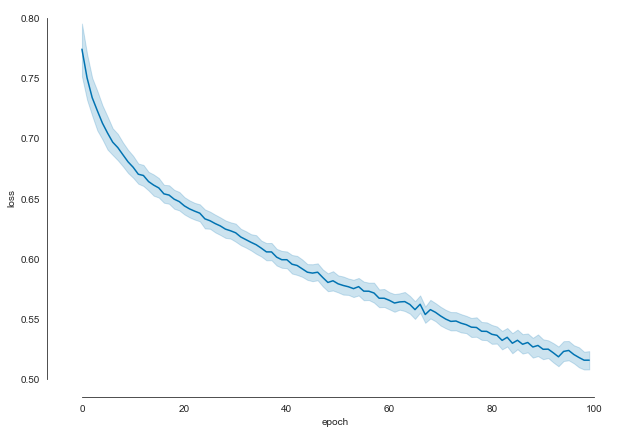

In [116]:
_, ax = plt.subplots(1,1,figsize=(10,7))
sns.lineplot(x = "epoch", y = "loss", data = pd.DataFrame({
    "epoch" : np.tile(np.arange(n_epochs),n_splits),
    "loss" : np.concatenate([x for x in df_loo.loss]),
}), ax = ax)
sns.despine(offset=10, trim=True, ax=ax)

### Evaluation metrics

In this case we can"t use the AUC-ROC and AP metrics on the test set, because there is always only one sample in the
test set. Therefore, we just look at the accuracy at testing.

Notations:
* ´acc_´ - Accuracy classification score.
* ´auc_roc_´ - Area Under the Receiver Operating Characteristic Curve (ROC AUC). "A receiver operating characteristic (ROC),
or simply ROC curve, is a graphical plot which illustrates the performance of a binary classifier system as its
discrimination threshold is varied. It is created by plotting the fraction of true positives out of the positives
(TPR = true positive rate) vs. the fraction of false positives out of the negatives (FPR = false positive rate), at
various threshold settings. TPR is also known as sensitivity, and FPR is one minus the specificity or true negative rate."
* ´ap_´ - "The precision-recall curve shows the tradeoff between precision and recall for different thresholds. A high
area under the curve represents both high recall and high precision, where high precision relates to a low false positive
 rate, and high recall relates to a low false negative rate. High scores for both show that the classifier is returning
 accurate results (high precision), as well as returning a majority of all positive results (high recall)."

The ´_tr´ suffix after each metric refers to the training set and ´_tst´ to the test set.

* **Training set**

In [117]:
df_loo.rename(columns={"acc_tr":"Accuracy", "auc_roc_tr":"AUC-ROC", "ap_tr":"AUC-PRC"}, inplace=True)

In [118]:
df_loo[df_loo.columns[4::]].describe()

,Accuracy,AUC-ROC,AUC-PRC
count,95.000,95.000,95.000
mean,0.789,0.855,0.829
std,0.050,0.044,0.052
min,0.656,0.700,0.641
25%,0.767,0.831,0.803
50%,0.800,0.862,0.832
75%,0.822,0.882,0.861
max,0.911,0.970,0.968


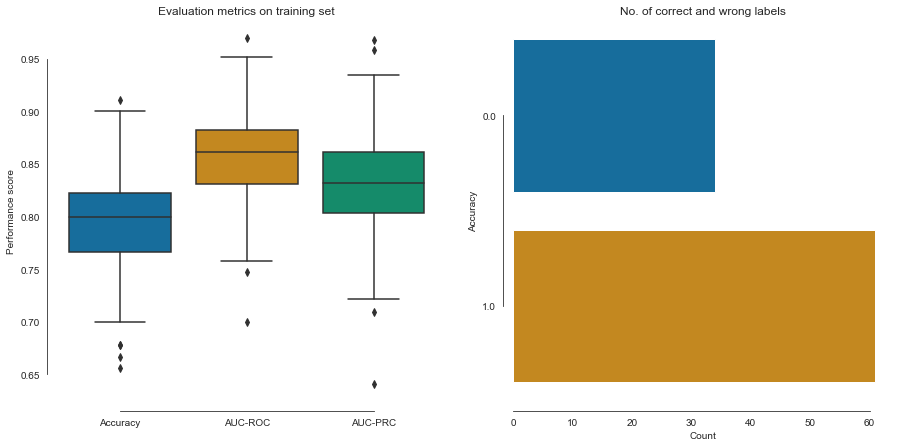

In [119]:
_, (ax1, ax2) = plt.subplots(1,2,figsize=(15,7))

sns.boxplot(x="variable", y="value", data=pd.melt(df_loo[["Accuracy", "AUC-ROC", "AUC-PRC"]]), ax = ax1)
ax1.set(xlabel="", ylabel="Performance score", title="Evaluation metrics on training set")
sns.despine(offset=10, trim=True, ax=ax1)

sns.countplot(y="acc_tst", data=df_loo, ax = ax2)
ax2.set(xlabel="Count", ylabel="Accuracy", title="No. of correct and wrong labels")
sns.despine(offset=10, trim=True, ax=ax2)

In [120]:
print("Worst performance splits : {}".format(str(df_loo[df_loo.Accuracy == df_loo.Accuracy.min()].index.values).strip("[]")))
print("Best performance splits: {}".format(str(df_loo[df_loo.Accuracy == df_loo.Accuracy.max()].index.values).strip("[]")))
print("Splits with performance outside of the IQR: {}".format(str(subset_out_iqr(df_loo, "Accuracy", whisker_width=1.5).index.values).strip("[]")))

Worst performance splits : 60
Best performance splits: 69
Splits with performance outside of the IQR: 13 51 58 60 69


In [121]:
print("Mean accuracy on test set : {:.2f}".format(df_loo.acc_tst.mean()))


Mean accuracy on test set : 0.64


On the test set the mean accuracy is only 64%, meaning that only 61 out of 95 of the individual patient sequences can be well explained using the population data.
We can check which sequences were correctly and wrongly classified:

In [122]:
print("Wrongly classified : {}".format(str(df_loo[df_loo.acc_tst == 0].index.values).strip("[]")))
print("Correctly classified: {}".format(str(df_loo[df_loo.acc_tst == 1].index.values).strip("[]")))

Wrongly classified :  3  6 11 21 24 26 30 31 32 36 37 40 41 44 50 51 52 53 54 55 59 60 62 63
 64 65 68 70 74 75 82 89 92 93
Correctly classified:  0  1  2  4  5  7  8  9 10 12 13 14 15 16 17 18 19 20 22 23 25 27 28 29
 33 34 35 38 39 42 43 45 46 47 48 49 56 57 58 61 66 67 69 71 72 73 76 77
 78 79 80 81 83 84 85 86 87 88 90 91 94


### Comparison plot of all data in the wrongly and correctly classified groups

In [123]:
from src.utils import clinical_data_decoder

df_nt = clinical_data_decoder(df_ema_enc)
nt_cols = [
    "Sex",
    "Lives alone",
    "Employment status",
    "Self-ratings of Physical Health",
    "Essential workers in household",
    "Worries about Life Stability",
    "Changes in Frequency of Social Interactions"
]

In [124]:
wrongly_cls_pids = [patient_lookup[x] for x in df_loo[df_loo.acc_tst == 0].index.values]
correctly_cls_pids = [patient_lookup[x] for x in df_loo[df_loo.acc_tst == 1].index.values]

comm_wr = df_temp[df_temp.user.isin(wrongly_cls_pids)]
comm_cr = df_temp[df_temp.user.isin(correctly_cls_pids)]

ema_wr = df_nt[df_nt.user.isin(wrongly_cls_pids)]
ema_cr = df_nt[df_nt.user.isin(correctly_cls_pids)]

#### Temporal data

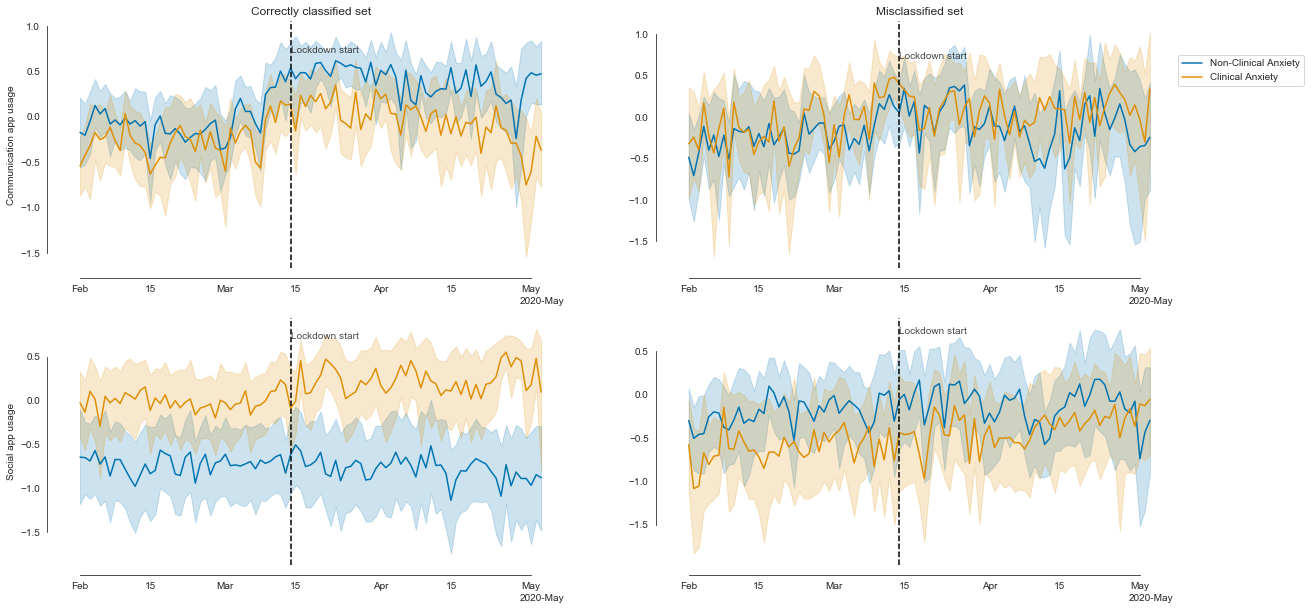

In [125]:
plot_loo_temp_data_comparison(comm_wr, comm_cr, figsize=(20, 10))

#### Relevant clinical data

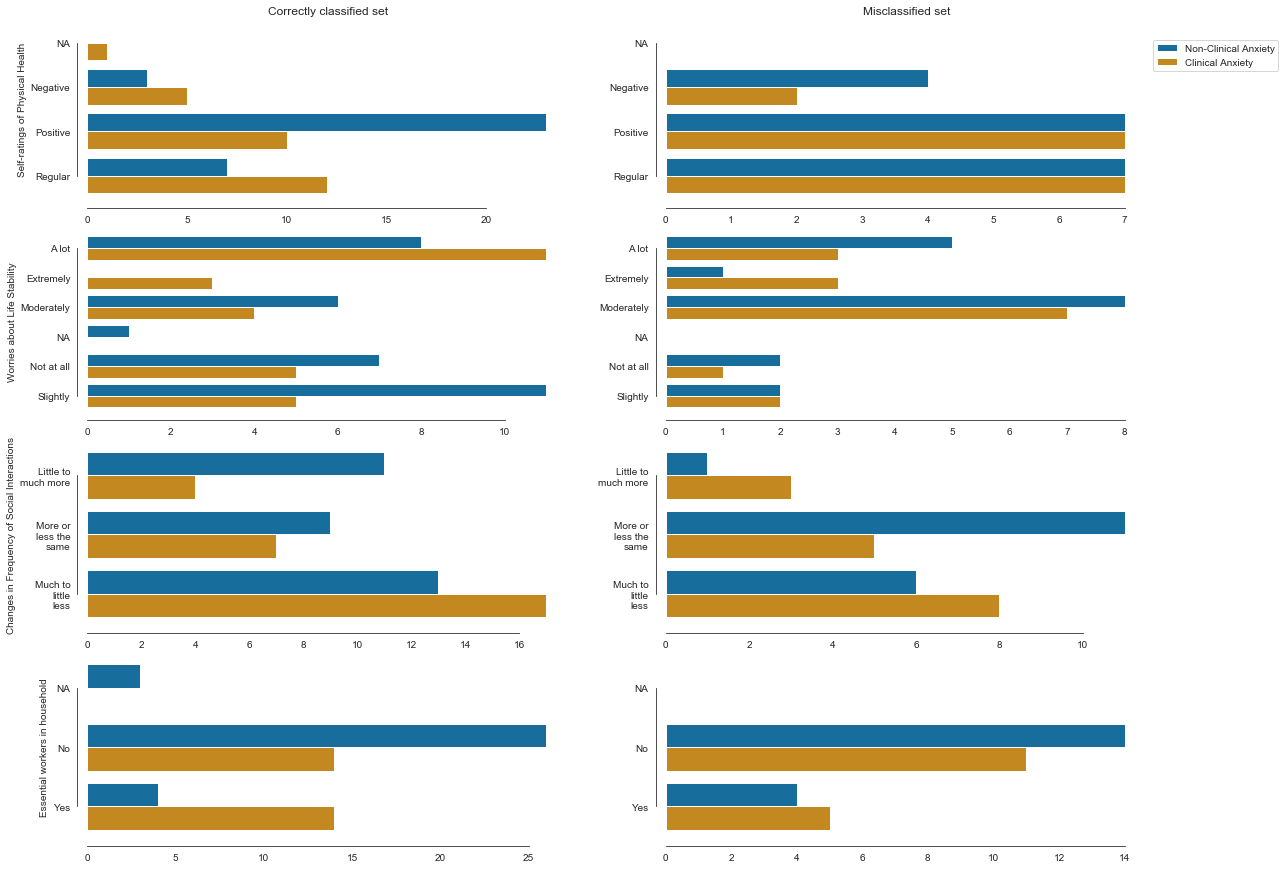

In [126]:
plot_loo_ema_data_comparison(
    ema_wr, ema_cr,
    ["Self-ratings of Physical Health",
     "Worries about Life Stability",
     "Changes in Frequency of Social Interactions",
     "Essential workers in household",],
    figsize=(19, 15)
)
